In [4]:
import h5py

def get_dataset_name(filename_with_dir):
    filename_without_dir = filename_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    print(dataset_name)
    return dataset_name

filename_path = "data/Intra/train/rest_105923_1.h5"
with h5py.File(filename_path, 'r') as f:
    dataset_name = get_dataset_name(filename_path)
    matrix = f.get(dataset_name)[()]
    print(type(matrix))
    print(matrix.shape)


rest_105923
<class 'numpy.ndarray'>
(248, 35624)


In [9]:
# downsample the data by taking every 10th time point (248, 3562)
matrix = matrix[:, ::10]
print(matrix.shape)


(248, 3563)


rest_105923
(248, 3563)
Matrix shape: (248, 3563)


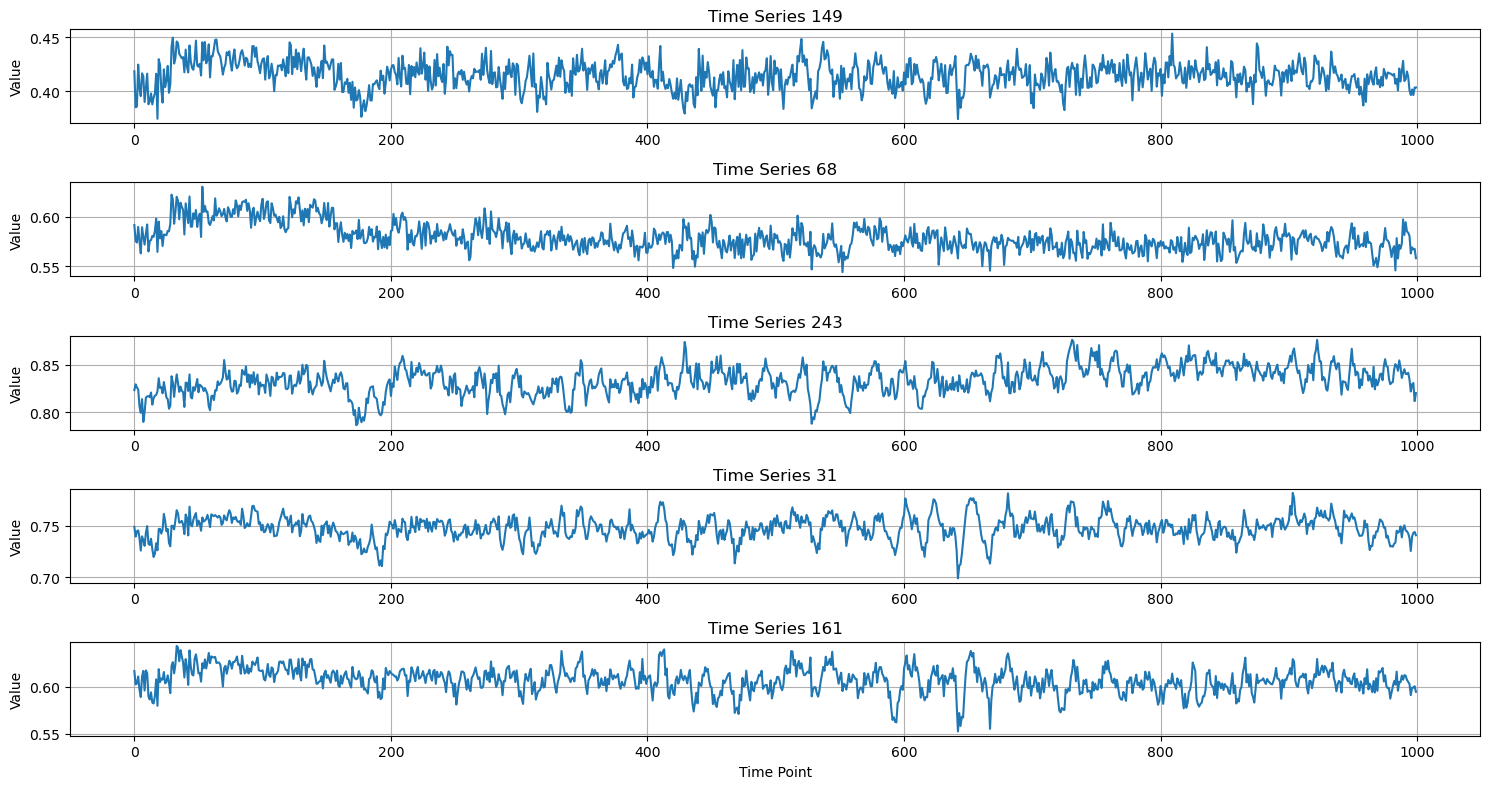

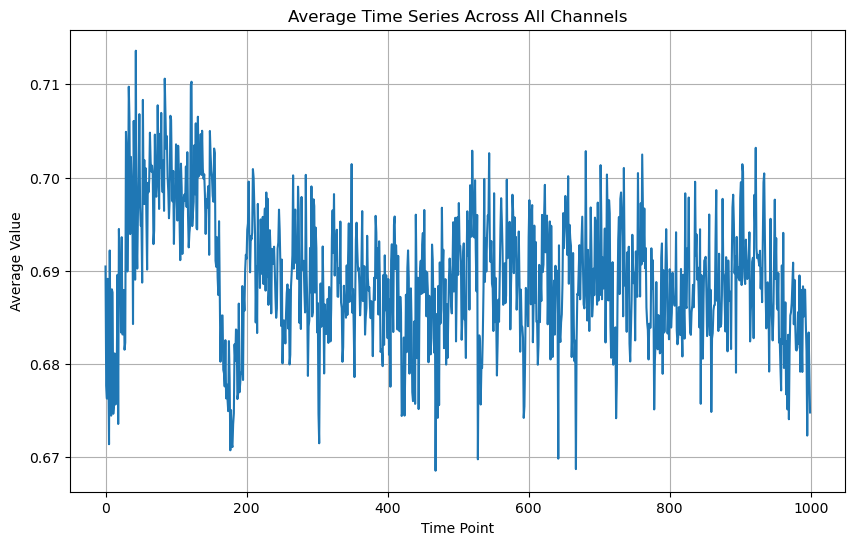

In [22]:
import numpy as np

import matplotlib.pyplot as plt

# Load the matrix data
filename_path = "data/Intra/train/rest_105923_1.h5"
with h5py.File(filename_path, 'r') as f:
    dataset_name = get_dataset_name(filename_path)
    matrix = f.get(dataset_name)[()]

# downsample the data by taking every 10th time point (248, 3562)
matrix = matrix[:, ::10]
print(matrix.shape)

# minmax normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
matrix = scaler.fit_transform(matrix)

# Matrix shape is (248, 35624) - 248 time series with 35624 time points each
print(f"Matrix shape: {matrix.shape}")

# Visualize a few time series
plt.figure(figsize=(15, 8))

# Plot 5 random time series
random_indices = np.random.choice(matrix.shape[0], 5, replace=False)
for i, idx in enumerate(random_indices):
    plt.subplot(5, 1, i+1)
    # Plot a subset of points to make visualization clearer
    sample_length = 1000  # Show first 1000 time points
    plt.plot(matrix[idx, :sample_length])
    plt.title(f'Time Series {idx}')
    plt.ylabel('Value')
    if i == 4:  # Only add x-label for the bottom plot
        plt.xlabel('Time Point')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the average time series
plt.figure(figsize=(10, 6))
mean_series = np.mean(matrix, axis=0)
plt.plot(mean_series[:1000])  # Plot first 1000 points of the mean series
plt.title('Average Time Series Across All Channels')
plt.xlabel('Time Point')
plt.ylabel('Average Value')
plt.grid(True)
plt.show()


Explained variance ratio by first 5 components: [0.47618226 0.26412845 0.13034278 0.02553641 0.01946778]
Cumulative explained variance for first 5 components: [0.47618226 0.74031071 0.87065349 0.8961899  0.91565767]


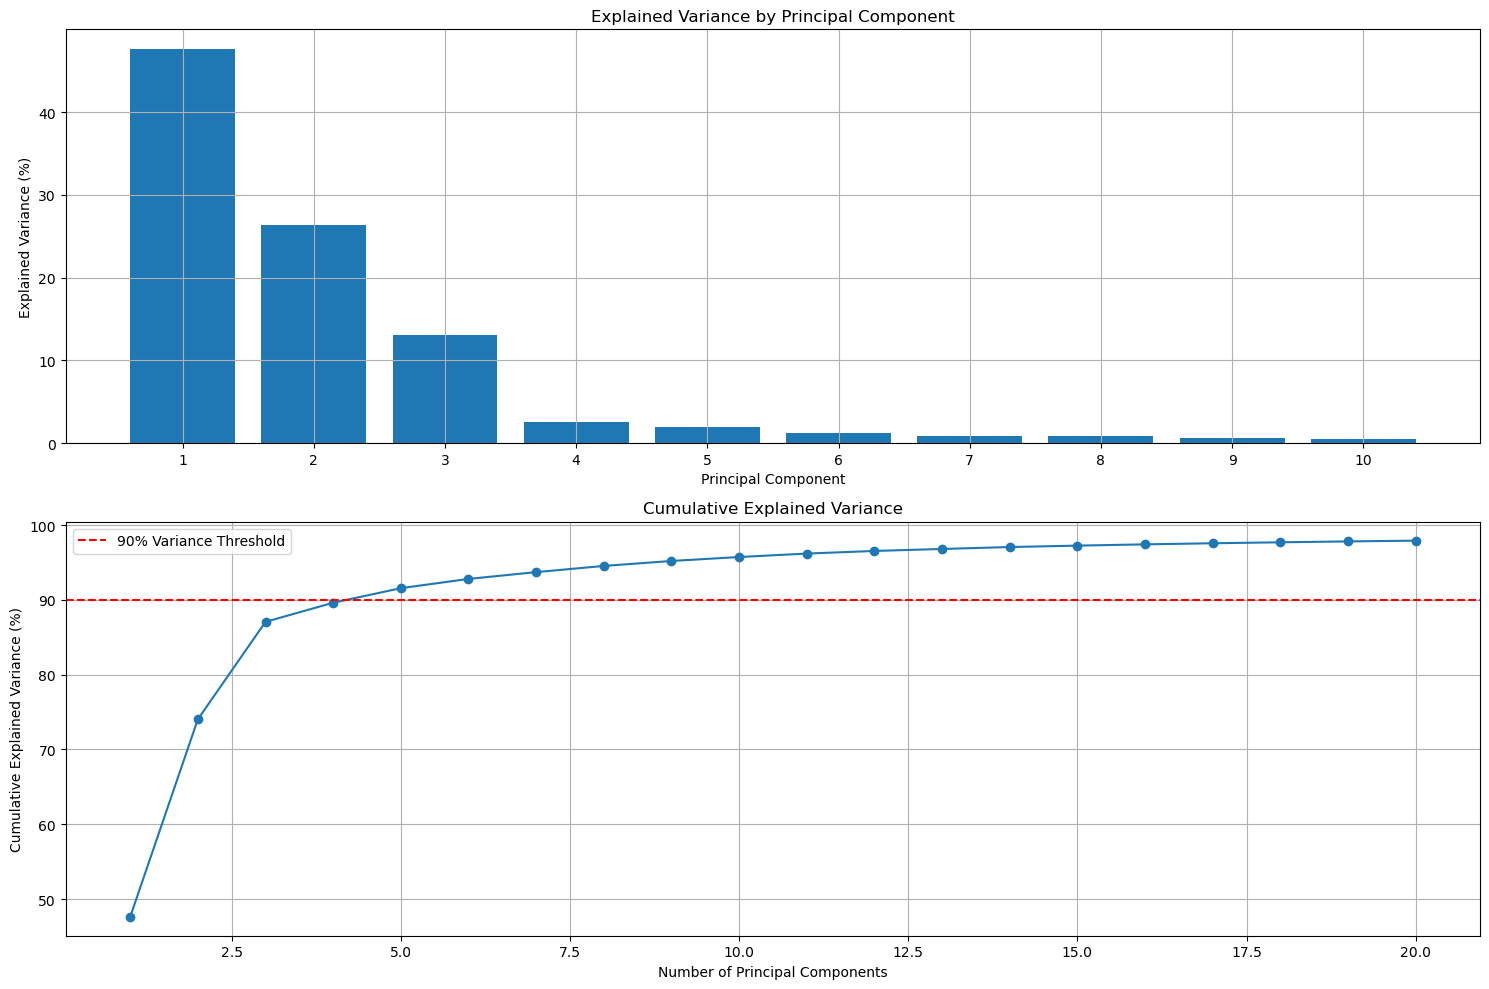

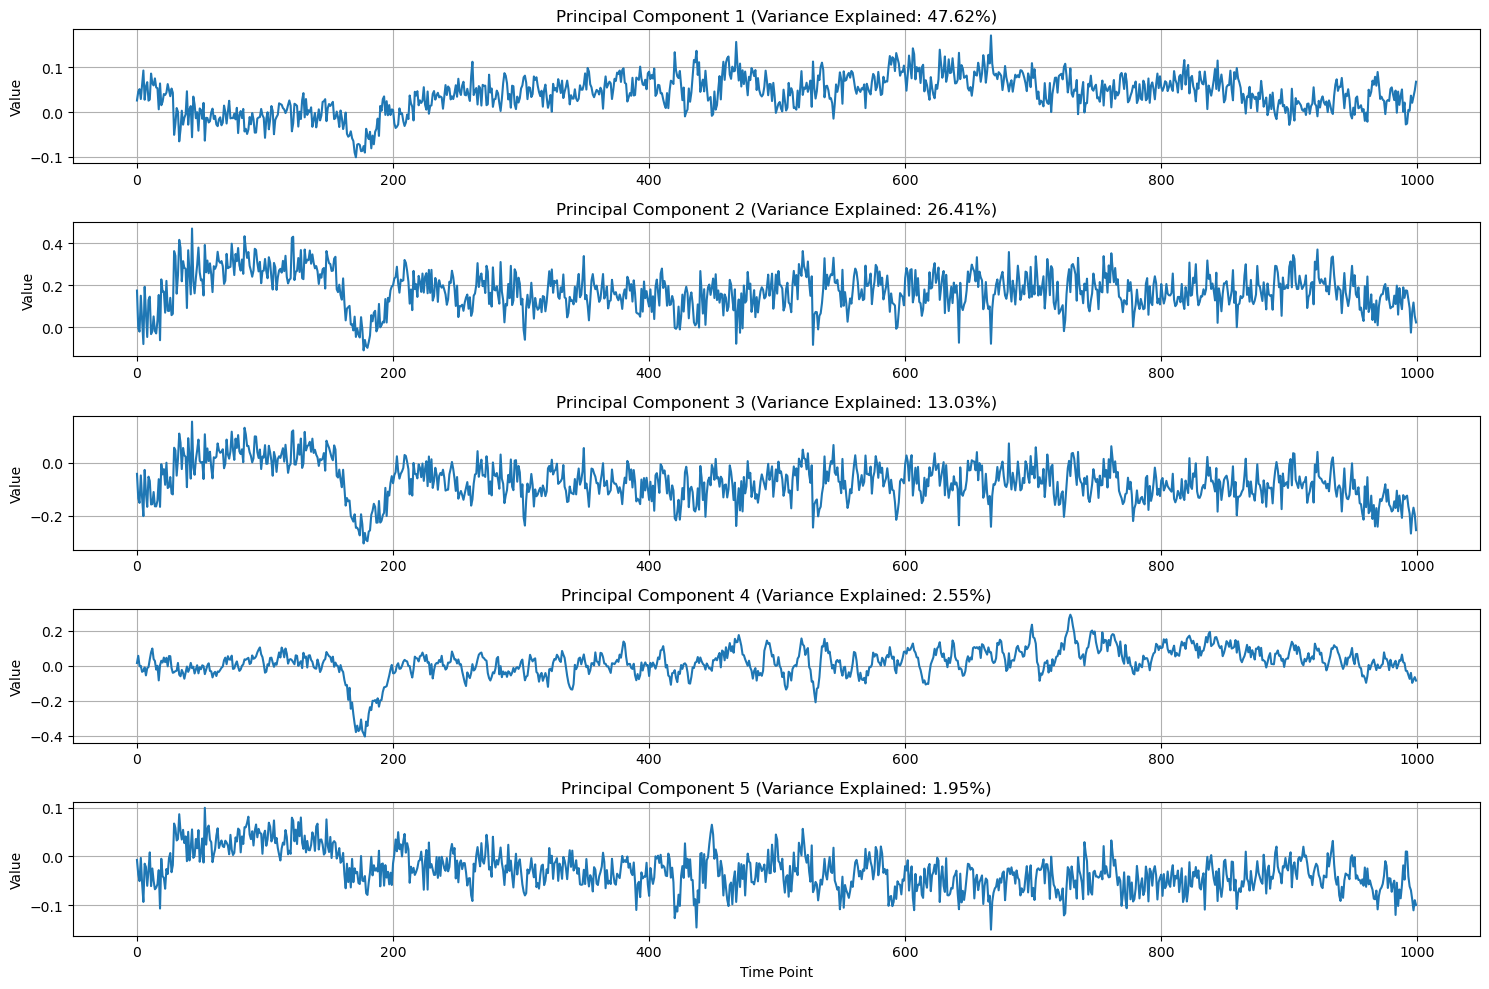

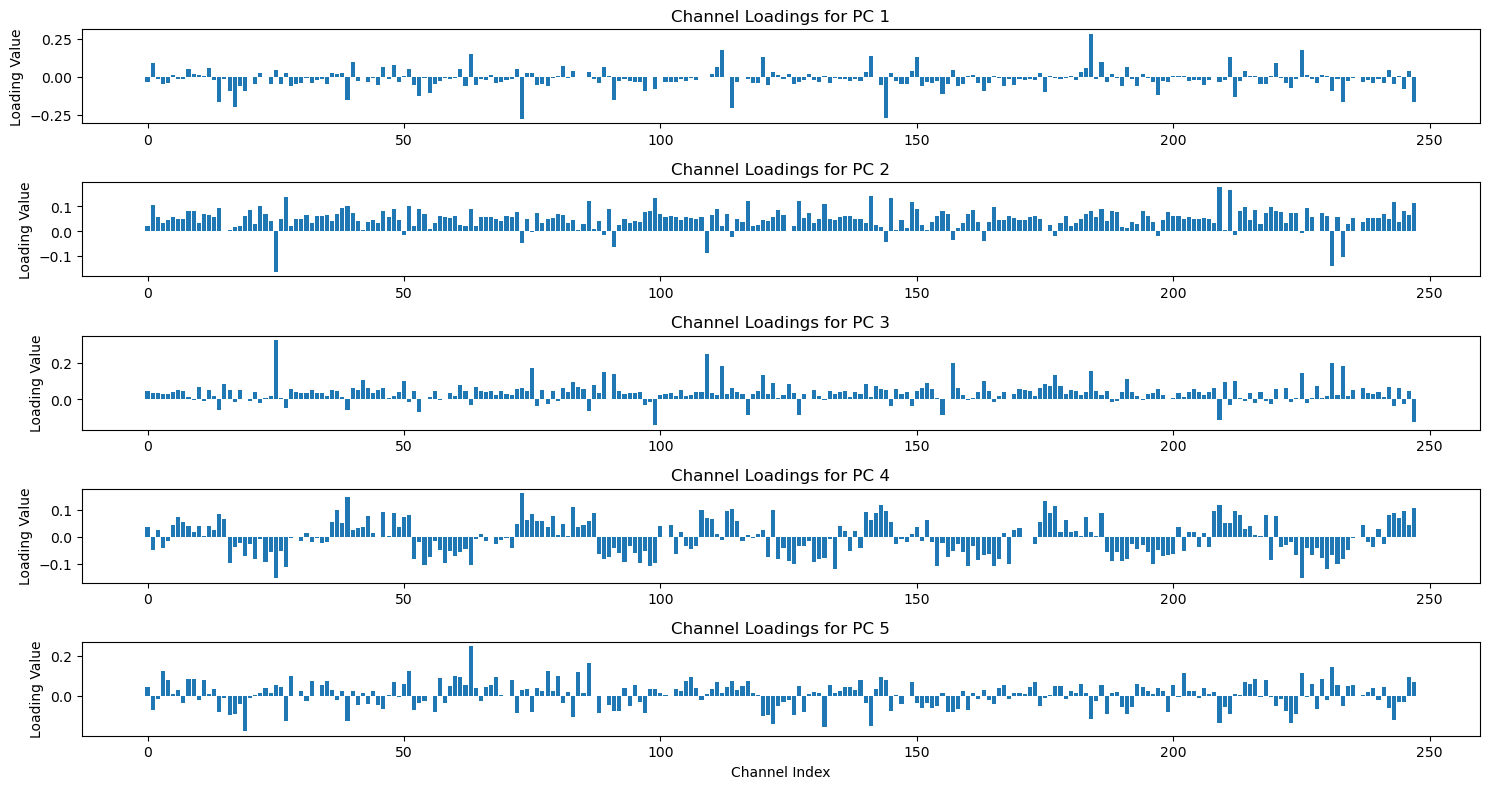

In [23]:
# Perform PCA on the time series data
from sklearn.decomposition import PCA

# Transpose the matrix to have time points as features and channels as samples
# This way we'll see how the channels vary over time
X = matrix.T  # Shape becomes (35624, 248)

# Initialize PCA without limiting components to see full variance explanation
pca = PCA()
pca.fit(X)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print variance explanation information
print(f"Explained variance ratio by first 5 components: {explained_variance[:5]}")
print(f"Cumulative explained variance for first 5 components: {cumulative_variance[:5]}")

# Plot the explained variance
plt.figure(figsize=(15, 10))

# Plot individual explained variance
plt.subplot(2, 1, 1)
plt.bar(range(1, 11), explained_variance[:10] * 100)
plt.title('Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, 11))
plt.grid(True)

# Plot cumulative explained variance
plt.subplot(2, 1, 2)
plt.plot(range(1, 21), cumulative_variance[:20] * 100, 'o-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.axhline(y=90, color='r', linestyle='--', label='90% Variance Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Now use the top 5 components for further analysis
n_components = 5
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X)

# Plot the principal components over time
plt.figure(figsize=(15, 10))
for i in range(n_components):
    plt.subplot(n_components, 1, i+1)
    plt.plot(principal_components[:1000, i])  # Plot first 1000 time points
    plt.title(f'Principal Component {i+1} (Variance Explained: {pca.explained_variance_ratio_[i]:.2%})')
    plt.ylabel('Value')
    if i == n_components-1:  # Only add x-label for the bottom plot
        plt.xlabel('Time Point')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the loadings (how each channel contributes to each principal component)
plt.figure(figsize=(15, 8))
for i in range(n_components):
    plt.subplot(n_components, 1, i+1)
    plt.bar(range(len(pca.components_[i])), pca.components_[i])
    plt.title(f'Channel Loadings for PC {i+1}')
    plt.ylabel('Loading Value')
    if i == n_components-1:
        plt.xlabel('Channel Index')
    
plt.tight_layout()
plt.show()


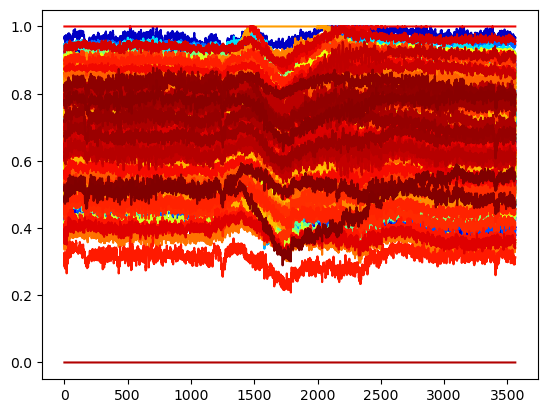

In [25]:
import matplotlib.pyplot as plt
import numpy as np

from FDApy.representation import DenseArgvals, DenseFunctionalData, DenseValues
from FDApy.simulation import KarhunenLoeve
from FDApy.preprocessing import UFPCA
from FDApy.visualization import plot

# Set general parameters
rng = 42
n_obs = matrix.shape[0]

# Parameters of the basis
name = "fourier"
n_functions = 25
argvals = DenseArgvals({"input_dim_0": np.linspace(0, 1, 101)})

# Use the matrix defined above instead of generating new data
# Convert the matrix to the format expected by the plot function
# Assuming matrix is already defined above and has the right dimensions

# Create a DenseFunctionalData object from the matrix
# We need to wrap the matrix in a DenseValues object first
n_samples = matrix.shape[0]  # Number of observations/samples
time_points = np.arange(matrix.shape[1])  # Time points for each sample

# Create the proper FDApy objects
argvals_dict = {"input_dim_0": time_points}
argvals = DenseArgvals(argvals_dict)
values = DenseValues(matrix)  # Wrap matrix in DenseValues object
data = DenseFunctionalData(argvals, values)

# Now plot the data using the FDApy plot function
_ = plot(data)
plt.show()

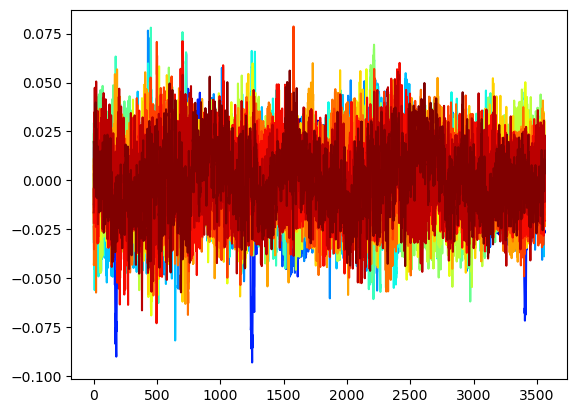

In [26]:
# First, we perform a univariate FPCA using a decomposition of the covariance operator.
ufpca_cov = UFPCA(n_components=20, method="covariance")
ufpca_cov.fit(data)

# Plot the eigenfunctions using the decomposition of the covariance operator.
_ = plot(ufpca_cov.eigenfunctions)
plt.show()


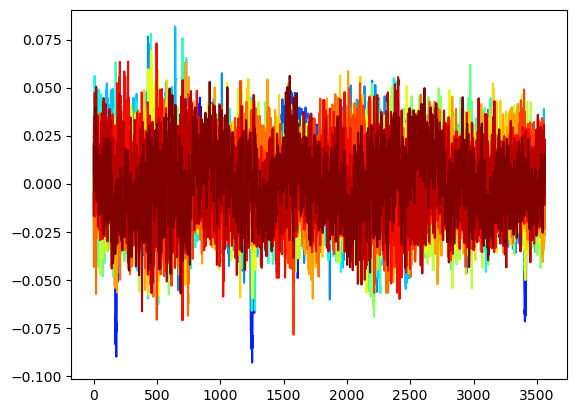

In [27]:
# Second, we perform a univariate FPCA using a decomposition of the inner-product matrix.
ufpca_innpro = UFPCA(n_components=20, method="inner-product")
ufpca_innpro.fit(data)

# Plot the eigenfunctions using the decomposition of the inner-product matrix.
_ = plot(ufpca_innpro.eigenfunctions)
plt.show()

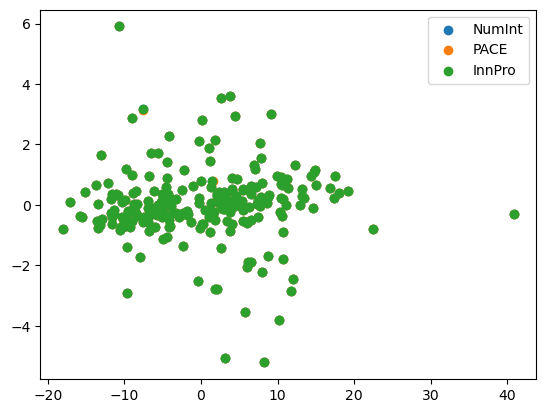

In [28]:
scores_numint = ufpca_cov.transform(data, method="NumInt")
scores_pace = ufpca_cov.transform(data, method="PACE")
scores_innpro = ufpca_innpro.transform(method="InnPro")

# Plot of the scores
plt.scatter(scores_numint[:, 0], scores_numint[:, 1], label="NumInt")
plt.scatter(scores_pace[:, 0], scores_pace[:, 1], label="PACE")
plt.scatter(scores_innpro[:, 0], scores_innpro[:, 1], label="InnPro")
plt.legend()
plt.show()

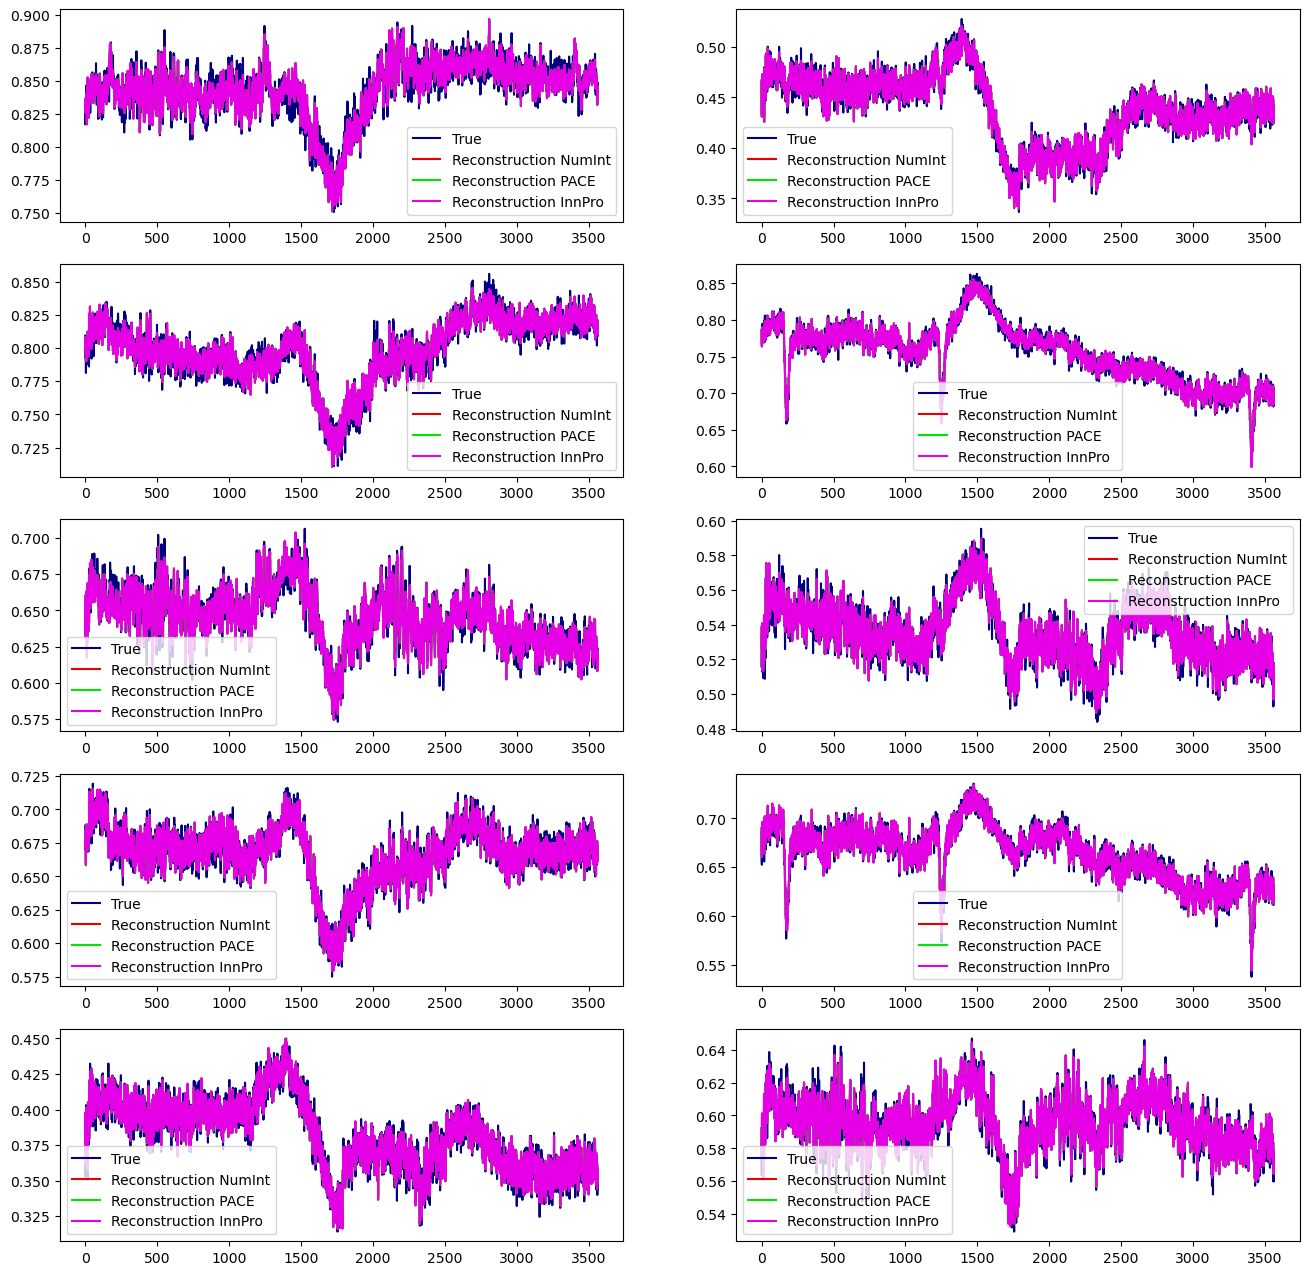

In [29]:
data_recons_numint = ufpca_cov.inverse_transform(scores_numint)
data_recons_pace = ufpca_cov.inverse_transform(scores_pace)
data_recons_innpro = ufpca_innpro.inverse_transform(scores_innpro)

colors_numint = np.array([[0.9, 0, 0, 1]])
colors_pace = np.array([[0, 0.9, 0, 1]])
colors_innpro = np.array([[0.9, 0, 0.9, 1]])

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))
for idx_plot, idx in enumerate(np.random.choice(data.n_obs, 10)):
    temp_ax = axes.flatten()[idx_plot]
    temp_ax = plot(data[idx], ax=temp_ax, label="True")
    plot(
        data_recons_numint[idx],
        colors=colors_numint,
        ax=temp_ax,
        label="Reconstruction NumInt",
    )
    plot(
        data_recons_pace[idx],
        colors=colors_pace,
        ax=temp_ax,
        label="Reconstruction PACE",
    )
    plot(
        data_recons_innpro[idx],
        colors=colors_innpro,
        ax=temp_ax,
        label="Reconstruction InnPro",
    )
    temp_ax.legend()
plt.show()

In [32]:
data_recons_pace.values.shape

(248, 3563)